In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.constraints import *
from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.table.grammar import *
from spatial_scene_grammars_examples.table.grammar_baseline import *
from spatial_scene_grammars_examples.table.grammar_decoration import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

from pydrake.all import Quaternion, RigidTransform

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Meshcat url:  http://127.0.0.1:7002/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [5]:
# Load and draw scene
with open("example_feasible_sampled_scene.pickle", "rb") as f:
    tree = pickle.load(f)
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url,  prefix="tree/contents")
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url,  prefix="tree/structure")

[2022-02-15 15:01:27.765] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


AttributeError: 'NoneType' object has no attribute 'nodes'

In [6]:
from blender_server.drake_blender_visualizer.blender_visualizer import (
    BlenderColorCamera
)

In [4]:
# Figure out where we're putting the camera for the scene by
# pointing it inwards, and then applying a yaw around
# the origin.
q = np.array([-0.264, -0.2, 0.568, 0.754])
q /= np.linalg.norm(q)
cam_tfs = [RigidTransform(p=[-1.16, 1.47, 1.38], quaternion=Quaternion(q))]

builder, mbp, scene_graph, _, _, = compile_scene_tree_to_mbp_and_sg(tree)
mbp.Finalize()
blender_vis = builder.AddSystem(BlenderColorCamera(
    scene_graph,
    draw_period=0.03333/2.,
    camera_tfs=cam_tfs,
    zmq_url="tcp://127.0.0.1:5556",
    env_map_path="/home/gizatt/tools/blender_server/data/env_maps/ballroom_4k.exr",
    out_prefix=os.path.join(os.getcwd(),"renders/"),
    resolution=[640*2, 480*2],
    cam_fov=np.pi/4,
    save_scene=True
))
builder.Connect(scene_graph.get_query_output_port(),
                blender_vis.get_input_port(0))
diagram = builder.Build()
context = diagram.CreateDefaultContext()
blender_vis.load()
blender_vis.bsi.send_remote_call(
    "register_light",
    name="window_light",
    type="SPOT",
    location=[0.42, -1.68, 1.76],
    quaternion=[0.345, 0.084, 0.416, -0.837],
    energy=200
)
context.SetTime(5.0)
diagram.Publish(context)

NameError: name 'tree' is not defined

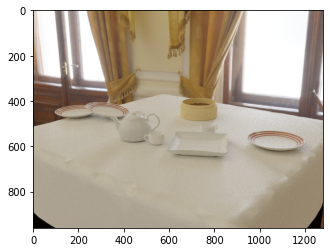

In [44]:
plt.imshow(plt.imread("renders/%02d_%08d.jpg" % (0, 0)))

# Render all scenes in a sample set from top-down view

In [14]:
trees_to_draw = []
#with open("target_dataset_examples.pickle", "rb") as f:
#with open("structure_constraint_examples.pickle", "rb") as f:
#with open("pre_fit_grammar_draws.pickle", "rb") as f:
#with open("post_fit_grammar_draws.pickle", "rb") as f:
#with open("baseline_post_fit_grammar_draws.pickle", "rb") as f:
with open("post_fit_grammar_draws_decorated.pickle", "rb") as f:
    while 1:
        try:
            #trees_to_draw.append(pickle.load(f))
            trees_to_draw.append(pickle.load(f)[0])
        except EOFError:
            break
print("Loaded %d environments" % len(trees_to_draw))
trees_to_draw = trees_to_draw[:30]

Loaded 30 environments


In [25]:
# Point camera straight down at scene
out_folder = "baseline_post_fit_post_sim"
for k, tree in tqdm(enumerate(trees_to_draw), total=len(trees_to_draw)):
    from pydrake.all import Quaternion
    cam_tfs = [RigidTransform(p=[0.,0.,3.2], quaternion=Quaternion([0., 0., 0., 1.]))]
    builder, mbp, scene_graph, _, _, = compile_scene_tree_to_mbp_and_sg(tree)
    mbp.Finalize()
    blender_vis = builder.AddSystem(BlenderColorCamera(
        scene_graph,
        draw_period=0.03333/2.,
        camera_tfs=cam_tfs,
        zmq_url="tcp://127.0.0.1:5556",
        env_map_path="/home/gizatt/tools/blender_server/data/env_maps/ballroom_4k.exr",
        out_prefix=os.path.join(os.getcwd(),"renders/%s/%04d/" % (out_folder, k)),
        resolution=[640*2, 480*2],
        cam_fov=np.pi/4,
        save_scene=False,
        raytraced=True
    ))
    builder.Connect(scene_graph.get_query_output_port(),
                    blender_vis.get_input_port(0))
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    blender_vis.load()
    blender_vis.bsi.send_remote_call(
        "register_light",
        name="window_light",
        type="SPOT",
        location=[0.42, -1.68, 1.76],
        quaternion=[0.345, 0.084, 0.416, -0.837],
        energy=200
    )
    context.SetTime(5.0)
    diagram.Publish(context)

  0%|          | 0/30 [00:00<?, ?it/s]

Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
Rendered a fra

b'Success'
Rendered a frame at 5.000000 seconds sim-time.
Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
Rendered a frame at 5.000000 seconds sim-time.
Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'S

b'Success'
Rendered a frame at 5.000000 seconds sim-time.
Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'


b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
Rendered a frame at 5.000000 seconds sim-time.


In [21]:
# Point camera at scene in a scenic way
out_folder = "post_fit_post_sim_decorated_scenic"
for k, tree in tqdm(enumerate(trees_to_draw[:30]), total=len(trees_to_draw)):
    q = np.array([-0.264, -0.2, 0.568, 0.754])
    q /= np.linalg.norm(q)
    cam_tfs = [RigidTransform(p=[-1.16, 1.47, 1.38], quaternion=Quaternion(q))]

    builder, mbp, scene_graph, _, _, = compile_scene_tree_to_mbp_and_sg(tree)
    mbp.Finalize()
    blender_vis = builder.AddSystem(BlenderColorCamera(
        scene_graph,
        draw_period=0.03333/2.,
        camera_tfs=cam_tfs,
        zmq_url="tcp://127.0.0.1:5556",
        env_map_path="/home/gizatt/tools/blender_server/data/env_maps/ballroom_4k.exr",
        out_prefix=os.path.join(os.getcwd(),"renders/%s/%04d/" % (out_folder, k)),
        resolution=[640*2, 480*2],
        cam_fov=np.pi/4,
        save_scene=False,
        raytraced=True
    ))
    builder.Connect(scene_graph.get_query_output_port(),
                    blender_vis.get_input_port(0))
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    blender_vis.load()
    blender_vis.bsi.send_remote_call(
        "register_light",
        name="window_light",
        type="SPOT",
        location=[0.42, -1.68, 1.76],
        quaternion=[0.345, 0.084, 0.416, -0.837],
        energy=200
    )
    context.SetTime(5.0)
    diagram.Publish(context)

  0%|          | 0/30 [00:00<?, ?it/s]

Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Failure: \'bpy_prop_collection[key]: key "material_plant::ShrimpDumplingsDecoration_31::model_0::shrimp_dumplings::0" not found\''
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Failure: \'bpy_prop_collection[key]: key "material_plant::ShrimpDumplingsDecoration_30::model_0::shrimp_dumplings::0" not found\''
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'S

b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
Rendered a frame at 5.000000 seconds sim-time.
Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'


b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Failure: \'bpy_prop_collection[key]: key "material_plant::ShrimpDumplingsDecoration_33::model_0::shrimp_dumplings::0" not found\''
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Failure: \'bpy_prop_collection[key]: key "material_plant::ShrimpDumplingsDecoration_34::model_0::shrimp_dumplings::0" not found\''
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Failure: \'bpy_

b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
Rendered a frame at 5.000000 seconds sim-time.
Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'


b'Success'
Rendered a frame at 5.000000 seconds sim-time.
Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'


# Load all images and render an "average" image
 

Text(0.5, 1.0, 'Overlay of 10 post-fit scenes, post-sim')

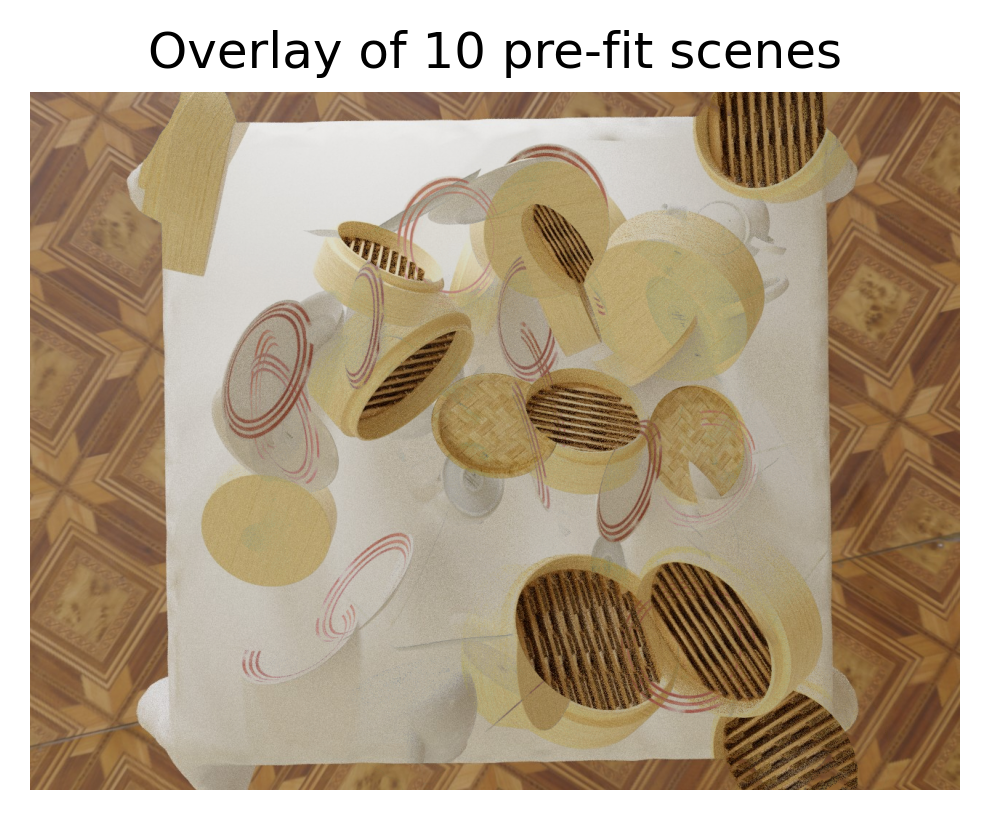

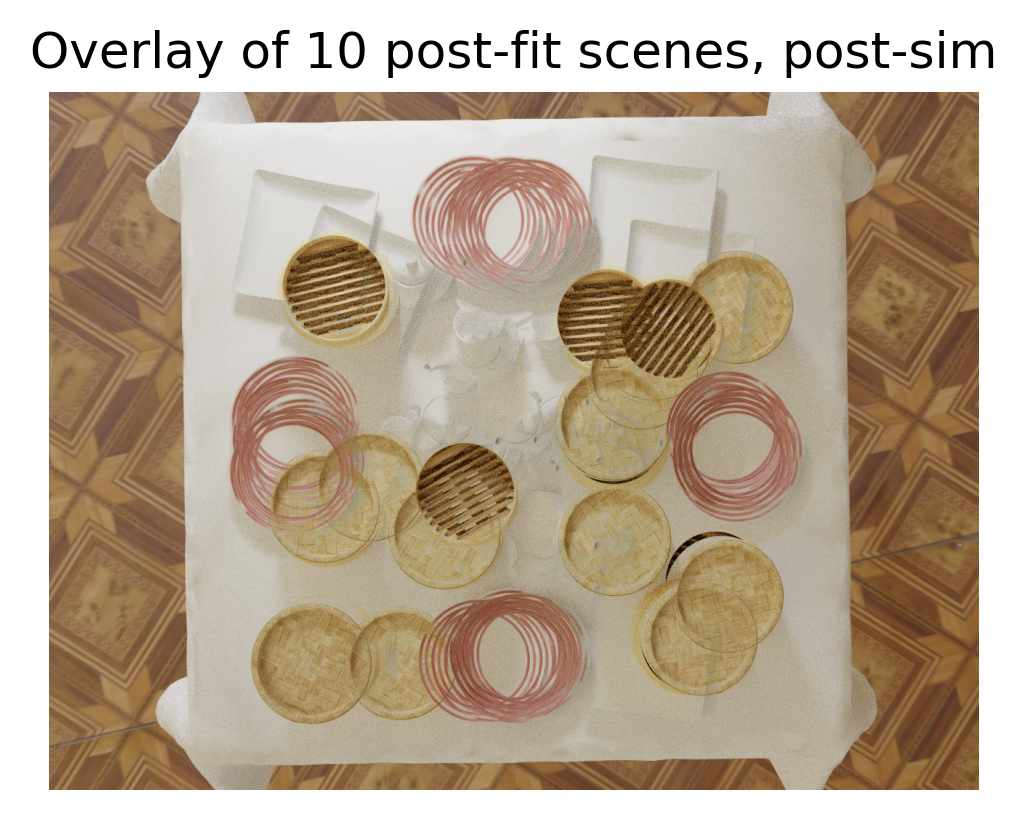

In [27]:
import glob
import cv2

def load_im(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_RGB2BGR).astype(np.float)/255.

def get_average_image(glob_string, background_path):
    im_paths = glob.glob(glob_string)[:10]
    background_image = load_im(background_path)
    ims = [load_im(path) - background_image for path in im_paths]
    return np.min(np.stack(ims, axis=0), axis=0) + background_image, len(im_paths)
    
    
plt.figure(dpi=300).set_size_inches(4, 4)
avg_im, N = get_average_image(glob_string = "renders/pre_fit/**/*.jpg", background_path="renders/table_background.jpg")
plt.imshow(avg_im)
plt.axis('off')
plt.title("Overlay of %d pre-fit scenes" % N)

plt.figure(dpi=300).set_size_inches(4, 4)
avg_im, N = get_average_image(glob_string = "renders/post_fit_post_sim/**/*.jpg", background_path="renders/table_background.jpg")
plt.imshow(avg_im)
plt.axis('off')
plt.title("Overlay of %d post-fit scenes, post-sim" % N)

# Render video with ffmpeg call

In [71]:
glob_string = "renders/post_fit_post_sim/**/*.jpg"
file_paths = glob.glob(glob_string)[:20]
out_filename = "renders/post_fit_post_sim_top_down.mp4"
file_path_filename = "file_paths.txt"
with open(file_path_filename, "w") as f:
    for file_path in file_paths:
        f.write("""file %s\n""" % file_path)

ffmpeg_call = "ffmpeg -y -r 2 -f concat -i %s -c:v libx264 -pix_fmt yuv420p -vf \"scale=1024:1024\" %s" % (
    file_path_filename, out_filename
)
print(ffmpeg_call)
os.system(ffmpeg_call)


ffmpeg -y -r 2 -f concat -i file_paths.txt -c:v libx264 -pix_fmt yuv420p -vf "scale=1024:1024" renders/post_fit_post_sim_top_down.mp4


0

In [29]:
glob_string = "renders/post_fit_post_sim_scenic/**/*.jpg"
file_paths = glob.glob(glob_string)[:20]
out_filename = "renders/post_fit_post_sim_scenic.mp4"
file_path_filename = "file_paths.txt"
with open(file_path_filename, "w") as f:
    for file_path in file_paths:
        f.write("""file %s\n""" % file_path)

ffmpeg_call = "ffmpeg -y -r 2 -f concat -i %s -c:v libx264 -pix_fmt yuv420p -vf \"scale=1024:1024, crop=1024:700:0:100\" %s" % (
    file_path_filename, out_filename
)
print(ffmpeg_call)
os.system(ffmpeg_call)


ffmpeg -y -r 2 -f concat -i file_paths.txt -c:v libx264 -pix_fmt yuv420p -vf "scale=1024:1024, crop=1024:700:0:100" renders/post_fit_post_sim_scenic.mp4


0

In [30]:
glob_string = "renders/baseline_post_fit_post_sim_scenic/**/*.jpg"
file_paths = glob.glob(glob_string)[:20]
out_filename = "renders/baseline_post_fit_post_sim_scenic.mp4"
file_path_filename = "file_paths.txt"
with open(file_path_filename, "w") as f:
    for file_path in file_paths:
        f.write("""file %s\n""" % file_path)

ffmpeg_call = "ffmpeg -y -r 2 -f concat -i %s -c:v libx264 -pix_fmt yuv420p -vf \"scale=1024:1024, crop=1024:700:0:100\" %s" % (
    file_path_filename, out_filename
)
print(ffmpeg_call)
os.system(ffmpeg_call)


ffmpeg -y -r 2 -f concat -i file_paths.txt -c:v libx264 -pix_fmt yuv420p -vf "scale=1024:1024, crop=1024:700:0:100" renders/baseline_post_fit_post_sim_scenic.mp4


0

In [73]:
glob_string = "renders/pre_fit_scenic/**/*.jpg"
file_paths = glob.glob(glob_string)[:20]
out_filename = "renders/pre_fit_scenic.mp4"
file_path_filename = "file_paths.txt"
with open(file_path_filename, "w") as f:
    for file_path in file_paths:
        f.write("""file %s\n""" % file_path)

ffmpeg_call = "ffmpeg -y -r 2 -f concat -i %s -c:v libx264 -pix_fmt yuv420p -vf \"scale=1024:1024, crop=1024:700:0:100\" %s" % (
    file_path_filename, out_filename
)
print(ffmpeg_call)
os.system(ffmpeg_call)


ffmpeg -y -r 2 -f concat -i file_paths.txt -c:v libx264 -pix_fmt yuv420p -vf "scale=1024:1024, crop=1024:700:0:100" renders/pre_fit_scenic.mp4


0

In [74]:
glob_string = "renders/examples_scenic/**/*.jpg"
file_paths = glob.glob(glob_string)[:20]
out_filename = "renders/examples_scenic.mp4"
file_path_filename = "file_paths.txt"
with open(file_path_filename, "w") as f:
    for file_path in file_paths:
        f.write("""file %s\n""" % file_path)

ffmpeg_call = "ffmpeg -y -r 2 -f concat -i %s -c:v libx264 -pix_fmt yuv420p -vf \"scale=1024:1024, crop=1024:700:0:100\" %s" % (
    file_path_filename, out_filename
)
print(ffmpeg_call)
os.system(ffmpeg_call)


ffmpeg -y -r 2 -f concat -i file_paths.txt -c:v libx264 -pix_fmt yuv420p -vf "scale=1024:1024, crop=1024:700:0:100" renders/examples_scenic.mp4


0

In [75]:
glob_string = "renders/structure_constraint_examples_scenic/**/*.jpg"
file_paths = glob.glob(glob_string)[:20]
out_filename = "renders/structure_constraint_examples_scenic.mp4"
file_path_filename = "file_paths.txt"
with open(file_path_filename, "w") as f:
    for file_path in file_paths:
        f.write("""file %s\n""" % file_path)

ffmpeg_call = "ffmpeg -y -r 2 -f concat -i %s -c:v libx264 -pix_fmt yuv420p -vf \"scale=1024:1024, crop=1024:700:0:100\" %s" % (
    file_path_filename, out_filename
)
print(ffmpeg_call)
os.system(ffmpeg_call)

ffmpeg -y -r 2 -f concat -i file_paths.txt -c:v libx264 -pix_fmt yuv420p -vf "scale=1024:1024, crop=1024:700:0:100" renders/structure_constraint_examples_scenic.mp4


0

In [16]:
glob_string = "renders/post_fit_post_sim_decorated_scenic/**/*.jpg"
file_paths = glob.glob(glob_string)[:20]
out_filename = "renders/post_fit_post_sim_decorated_scenic.mp4"
file_path_filename = "file_paths.txt"
with open(file_path_filename, "w") as f:
    for file_path in file_paths:
        f.write("""file %s\n""" % file_path)

ffmpeg_call = "ffmpeg -y -r 2 -f concat -i %s -c:v libx264 -pix_fmt yuv420p -vf \"scale=1024:1024\" %s" % (
    file_path_filename, out_filename
)
print(ffmpeg_call)
os.system(ffmpeg_call)


ffmpeg -y -r 2 -f concat -i file_paths.txt -c:v libx264 -pix_fmt yuv420p -vf "scale=1024:1024" renders/post_fit_post_sim_decorated_scenic.mp4


0

# Get precise scene tree renderings from meshcat

In [17]:
q = np.array([-0.264, -0.2, 0.568, 0.754])
q /= np.linalg.norm(q)
cam_tf = RigidTransform(p=[-1.16, 1.47, 1.38], quaternion=Quaternion(q))
resolution=[640*2, 480*2]
cam_fov=np.pi/4

lookat_point = cam_tf.multiply(np.array([0., 0., -3.]))
print(lookat_point)

[ 0.64300469 -0.78095021  0.5539266 ]


In [18]:
from IPython.display import HTML
HTML("""
    <div style="height: {height}px; width: {width}px; overflow-x: visible; overflow-y: visible; resize: none">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url, width=resolution[0], height=resolution[1]))

In [19]:
fit_grammar = SpatialSceneGrammar(
    root_node_type = Table,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.0, 0., 0.8])),
)
fit_grammar.load_state_dict(torch.load("fit_grammar.torch"))

def draw_tree_on_rendering(scene_num):
    # Get observed nodes, which have good tfs; re-parse best tree (so that
    # structure matches physically-settled objects better); draw that.
    observed_nodes = trees_to_draw[scene_num].get_observed_nodes()
    tree_copy = infer_mle_tree_with_mip_from_proposals(
        fit_grammar, observed_nodes, {}, verbose=0, N_solutions=1
    )[0]
    
    for node in tree_copy.nodes:
        node.translation = node.translation - lookat_point
        
    vis.delete()
    #draw_scene_tree_contents_meshcat(tree_copy, zmq_url=vis.window.zmq_url,  prefix="tree/contents")
    draw_scene_tree_structure_meshcat(tree_copy, zmq_url=vis.window.zmq_url,  prefix="tree/structure",
                                      with_triad=False, linewidth=30, node_sphere_size=0.02)
    
    # Cam fov is horizontal; we want vertical.
    Va = float(resolution[1]) / resolution[0]
    Vf = np.arctan( np.tan(cam_fov/2) * Va ) * 2 * 180. / np.pi
    print(Vf)
    cam = meshcat_geom.PerspectiveCamera(fov=Vf, zoom=1)
    vis["/Cameras/default/rotated"].set_object(cam)
    vis['/Cameras/default'].set_transform(
        RigidTransform(p=lookat_point).inverse().multiply(cam_tf).GetAsMatrix4()
    )
    vis['/Cameras/default/rotated/<object>'].set_property(
        'position', [0, 0, 0]
    )
    # Vertical FOV in degrees: 
    # Turn off background, axes, and grid.
    vis['/Background'].set_property("visible", False)
    vis['/Grid'].set_property("visible", False)
    vis['/Axes'].set_property("visible", False)

    # Overlay
    from PIL import Image
    folder = "renders/post_fit_post_sim_decorated_scenic/%04d/" % scene_num

    im1 = os.path.join(folder, "00_00000000.jpg")
    im1 = np.array(Image.open(im1)) / 255.
    im2 = np.array(vis.get_image().resize(resolution)) / 255.

    #plt.figure(dpi=300).set_size_inches(6, 6)
    alpha_mask = im2[:, :, 3:].repeat(3, axis=-1) * 0.5
    combined = im1*(1. - alpha_mask) + im2[:, :, :3] * alpha_mask
    #plt.imshow(np.clip(combined, 0, 255), vmin=0, vmax=255)
    #plt.imshow(combined)
    #plt.axis("off")

    Image.fromarray((combined*255).astype(np.uint8)).save(os.path.join(folder, "00_00000000_with_tree.jpg"))

for scene_num in range(len(trees_to_draw)):
    draw_tree_on_rendering(scene_num)

ValueError: ("Grammar invalid for observation: can't explain observed node ", <spatial_scene_grammars_examples.table.grammar_decoration.EggTartsDecoration object at 0x7f460d28d208>)

In [15]:
glob_string = "renders/structure_constraint_examples_scenic/**/[0-9]*_[0-9]*_with_tree.jpg"
file_paths = glob.glob(glob_string)[:20]
out_filename = "renders/structure_constraint_examples_scenic_with_trees.mp4"
print(file_paths)
file_path_filename = "file_paths.txt"
with open(file_path_filename, "w") as f:
    for file_path in file_paths:
        f.write("""file %s\n""" % file_path)

ffmpeg_call = "ffmpeg -y -r 2 -f concat -i %s -c:v libx264 -pix_fmt yuv420p -vf \"scale=1024:1024, crop=1024:700:0:100\" %s" % (
    file_path_filename, out_filename
)
print(ffmpeg_call)
os.system(ffmpeg_call)

['renders/structure_constraint_examples_scenic/0004/00_00000000_with_tree.jpg', 'renders/structure_constraint_examples_scenic/0013/00_00000000_with_tree.jpg', 'renders/structure_constraint_examples_scenic/0001/00_00000000_with_tree.jpg', 'renders/structure_constraint_examples_scenic/0014/00_00000000_with_tree.jpg', 'renders/structure_constraint_examples_scenic/0012/00_00000000_with_tree.jpg', 'renders/structure_constraint_examples_scenic/0008/00_00000000_with_tree.jpg', 'renders/structure_constraint_examples_scenic/0003/00_00000000_with_tree.jpg', 'renders/structure_constraint_examples_scenic/0010/00_00000000_with_tree.jpg', 'renders/structure_constraint_examples_scenic/0002/00_00000000_with_tree.jpg', 'renders/structure_constraint_examples_scenic/0000/00_00000000_with_tree.jpg', 'renders/structure_constraint_examples_scenic/0011/00_00000000_with_tree.jpg', 'renders/structure_constraint_examples_scenic/0005/00_00000000_with_tree.jpg', 'renders/structure_constraint_examples_scenic/0007/

0